In [1]:
import cobra
from optlang.symbolics import add
import numpy as np
from cobra import Model, Reaction, Metabolite
import matplotlib.pyplot as plt
import pandas as pd
from cobra.flux_analysis import flux_variability_analysis
from copy import deepcopy

# Customized functions

### set glycerol minimal medium

In [2]:
def set_glycerol_minimal_medium(model, f_glycerl, f_nh4, f_fe3):
    
    # set lower bound of all exchange reactions to zero
    for rxn in model.exchanges:
        rxn.lower_bound = 0

    # turn on specific fluxes
    minimal__media = {
            'EX_nh4_e_': -f_nh4,     # ammonium
            'EX_pi_e_':  -1000,      # phosphate
            'EX_so4_e_': -1000,      # sulfate
            'EX_fe3_e_': -f_fe3,      # fe3+
            'EX_mn2_e_': -1000,      # mn2+
            'EX_zn2_e_': -1000,      # zn2+
            'EX_cu2_e_': -1000,      # cu2+
            'EX_ca2_e_': -1000,      # ca2+
            'EX_cl_e_' : -1000,      # cl-
            'EX_cobalt2_e_': -1000,  # cobalt
            'EX_k_e_':   -1000,      # k
            'EX_mobd_e_'   : -1000,  # mo6+
            'EX_na1_e_'    : -1000,  # na+
            'EX_ni2_e_'    : -1000,  # ni2+
            'EX_mg2_e_': -1000,      # mg2+
            'EX_o2_e_':  -18
        }

    for r in minimal__media.keys():
        try:
            rxn = model.reactions.get_by_id(r)
            rxn.lower_bound = minimal__media[r]
            rxn.upper_bound = 1000
        except:
            print("The reaction {} does not exist in model.".format(str(r)))
            continue
        
    # fix glycerol flux to set point
    model.reactions.get_by_id('EX_glyc_e_').lower_bound = -f_glycerl
    model.reactions.get_by_id('EX_glyc_e_').upper_bound = -f_glycerl
    
    return model

### add constraint to the total flux of a metabaolite

In [29]:
def add_flux_constraint(model, compound_id):
    
    # find stoichiometric coefficients of all reactions that produce/consume a metabolite
    S_dict = {}
    for r in model.reactions:
        for m in r.reactants:
            if m.id == compound_id:
                S_dict[r.id] = r.get_coefficient(compound_id)
                break           
        for m in r.products:
            if m.id == compound_id:
                S_dict[r.id] = r.get_coefficient(compound_id)
                break
                    
    # add flux constraint
    producing_fluxes = []
    for k,v in S_dict.items():
        if v>0:
            varX = model.problem.Variable('X_' + k, lb=0, ub=1, type='binary')
            con0A = model.problem.Constraint(model.reactions.get_by_id(k).flux_expression,
                                             name = 'con0A_' + k,
                                             indicator_variable=varX,
                                             active_when=0,
                                             ub=0)
            con0B = model.problem.Constraint(model.reactions.get_by_id(k).flux_expression,
                                             name = 'con0B_' + k,
                                             indicator_variable=varX,
                                             active_when=1,
                                             lb=0)
        else:
            varX = model.problem.Variable('X_' + k, lb=0, ub=1, type='binary')
            con0A = model.problem.Constraint(model.reactions.get_by_id(k).flux_expression,
                                             name = 'con0A_' + k,
                                             indicator_variable=varX,
                                             active_when=0,
                                             lb=0)
            con0B = model.problem.Constraint(model.reactions.get_by_id(k).flux_expression,
                                             name = 'con0B_' + k,
                                             indicator_variable=varX,
                                             active_when=1,
                                             ub=0)

        # refer to https://www.researchgate.net/post/How_can_I_linearize_the_product_of_two_variables for how to encode Z = X * Flux
        flux_ub = model.reactions.get_by_id(k).upper_bound
        flux_lb = model.reactions.get_by_id(k).lower_bound
            
        varZ = model.problem.Variable('Z_' + k, lb=min([0,flux_lb]), ub=flux_ub)
        con1 = model.problem.Constraint(varZ - flux_ub*varX, name = 'con1_' + k, ub=0)
        con2 = model.problem.Constraint(varZ - flux_lb*varX, name = 'con2_' + k, lb=0)
        con3 = model.problem.Constraint(varZ - model.reactions.get_by_id(k).flux_expression + (1-varX)*flux_ub, name = 'con3_' + k, lb=0)
        con4 = model.problem.Constraint(varZ - model.reactions.get_by_id(k).flux_expression + (1-varX)*flux_lb, name = 'con4_' + k, ub=0)
                    
        producing_fluxes.append(varZ*v)
        model.add_cons_vars([varX, varZ, con0A, con0B, con1, con2, con3, con4])
        model.solver.update()   
        #print(k, v, model.slim_optimize())
            
    flux_constraint = model.problem.Constraint(add(*producing_fluxes), lb=-1000, ub=1000, name="flux_constraint__%s"%(compound_id))
    model.add_cons_vars([flux_constraint])
    model.solver.update()
    
    return model, S_dict

### set CPLEX parameters

In [26]:
def set_cplex_parameters(model, verbose):
    model.solver = 'cplex'
    model.solver.configuration.lp_method = "barrier"
    model.solver.configuration.qp_method = "barrier"
    model.solver.configuration.presolve = True
    model.solver.configuration.tolerances.integrality = 1e-6
    model.solver.problem.parameters.mip.tolerances.integrality.set(1e-6)
    model.solver.configuration.verbosity=verbose
    model.solver.problem.parameters.emphasis.mip.set(1) 
    model.solver.problem.parameters.mip.strategy.probe.set(3)
    model.solver.problem.parameters.mip.strategy.rinsheur.set(20)
    model.solver.problem.parameters.mip.strategy.nodeselect.set(2)
    model.solver.problem.parameters.mip.strategy.heuristicfreq.set(20)
    
    return model

### fix loops in NADH production and consumption

In [70]:
def fix_NADH_NADPH_flux_loop(model):
    
    # NADTRHD, FMNRx and FMNR2r form a loop
    # NADTRHD: nad_c + nadph_c --> nadh_c + nadp_c
    # FMNRx: fmn_c + h_c + nadh_c --> fmnh2_c + nad_c        # missing in iMO1053
    # FMNR2r: fmn_c + h_c + nadph_c <=> fmnh2_c + nadp_c     # missing in iMO1053
    model.reactions.FMNR2r.lower_bound = 0
    
    # GLYD: h_c + hpyr_c + nadh_c <==> glyc_R_c + nad_c      # found in iMO1053, found in Pseudocyc (forward), found in Metacyc (bidirectional)
    # TRSARr: 2h3oppan_c + h_c + nadh_c <=> glyc_R_c + nad_c # missing in iMO1053,  missing in Pseudocyc, found in Metacyc (forward)
    model.reactions.GLYD.lower_bound = 0
    model.reactions.TRSARr.lower_bound = 0

    # Set of reactions that couple NADH/NAD to NADPH/NADP
    # the first two reactions are found in Metacyc, Pathway: 9-cis, 11-trans-octadecadienoyl-CoA degradation 
    # HACD31i: 3hhd58coa_c + nad_c --> 3ohd58ccoa_c + h_c + nadh_c
    # ECOAH36: 3hhd58coa_c <=> h2o_c + td58_2_coa_c                       # also found in Pseudocyc (Reverse)
    # RECOAH24: R_3htd58coa_c <=> h2o_c + td58_2_coa_c
    # RHACOAR142: 3ohd58coa_c + h_c + nadph_c <=> R_3htd58coa_c + nadp_c
    #
    # Reactions starting with "RECOAH" seems to be specific to PP but lack evidence in PA
    # We assume that they can flow in the reverse direction, similar to ECOAH36
    for r in model.reactions:
        if r.id.startswith('RECOAH'):
            r.upper_bound = 0

    # We did not find evidences that NAD/NADH is substrate of fdxr_42_c in both Pseudocyc and iMO1053
    model.reactions.FRDO6r.lower_bound=0
    model.reactions.FRDO6r.upper_bound=0
    model.reactions.FRDO7r.lower_bound=0
    model.reactions.FRDO7r.upper_bound=0

    # GLUDx and GLUDy in Pseudocyc goes forward direction
    # GLUDx: glu__L_c + h2o_c + nad_c ⇌ akg_c + h_c + nadh_c + nh4_c
    # GLUDy: glu__L_c + h2o_c + nadp_c ⇌ akg_c + h_c + nadph_c + nh4_c
    model.reactions.GLUDx.lower_bound = 0
    model.reactions.GLUDy.lower_bound = 0

    # CO2 will be gone after released
    model.reactions.H2CO3D.upper_bound = 0
    model.reactions.HCO3E.upper_bound = 0

    # SHK3Dr and SHK3D are the same reaction but conflict in reversibility
    model.reactions.SHK3Dr.lower_bound = 0

    # PRPP is irreversible
    model.reactions.PRPPS.lower_bound = 0
    
    # LEUDHr, VALDHr, ILEDHr are all reversible, which can be coupled to generate high flux in NADH.
    # Make them irreversible (reactions go in the direction of producing NH4).
    model.reactions.LEUDHr.lower_bound = 0
    model.reactions.VALDHr.lower_bound = 0
    model.reactions.ILEDHr.lower_bound = 0
    
    # PDHcr: dhlam_c + nad_c <=> h_c + lpam_c + nadh_c
    # iMO1053: forward direction
    model.reactions.PDHcr.lower_bound = 0
    
    # Loop for h_c
    # GLCP4: bglyg4n_c + 4.0 pi_c --> 4.0 g1p_c
    # GLGC: atp_c + g1p_c + h_c --> adpglc_c + ppi_c
    # GLCS3: 4.0 adpglc_c --> 4.0 adp_c + glyg4n_c + 4.0 h_c
    # GLBRAN3: glyg4n_c --> bglyg4n_c

    # Decouple conversion between NADPH and NADP (both found in iMO1053)
    # NADTRHD: nad_c + nadph_c --> nadh_c + nadp_c
    # THD2pp: 2 h_p + nadh_c  nadp_c --> 2 h_c + nad_c + nadph_c
    #model.reactions.NADTRHD.upper_bound = 0
    #model.reactions.THD2pp.upper_bound = 0
    
    return model

# Code Testing

In [63]:
model = cobra.io.load_json_model('../add_RL_production/SI3_iJN1411final_flux_w_rhamnolipid_biosynthesis.json')
model = set_glycerol_minimal_medium(model, 10, 1000, 1000)
model = set_cplex_parameters(model, 0)
model = fix_NADH_NADPH_flux_loop(model)
compound_id = 'nadph_c'
model, S_dict = add_flux_constraint(model, compound_id)

metabolite_producing_flux = 100
model.constraints["flux_constraint__%s"%(compound_id)].ub = metabolite_producing_flux
model.constraints["flux_constraint__%s"%(compound_id)].lb = metabolite_producing_flux

model.optimize()

,fluxes,reduced_costs
13DAMPPabcpp,0.0,NaN
13DAMPPtex,0.0,NaN
15DAPabcpp,0.0,NaN
1P2CBXLCYCL,0.0,NaN
1P2CBXLR,0.0,NaN
...,...,...
LRHHtex,0.0,NaN
LLRHHtex,0.0,NaN
EX_haa_e_,0.0,NaN
EX_lrhh_e_,0.0,NaN


In [64]:
model.metabolites.nadh_c.summary()

In [65]:
model.metabolites.nadph_c.summary()

In [66]:
model.metabolites.h_c.summary()

,,PERCENT,FLUX,REACTION_STRING
RXN_STAT,ID,,,
PRODUCING,GLCS3,100.0,999997.128373,4.0 adpglc_c --> 4.0 adp_c + glyg4n_c + 4.0 h_c
CONSUMING,GLGC,100.0,999997.128373,atp_c + g1p_c + h_c --> adpglc_c + ppi_c


In [72]:
model.metabolites.glyg4n_c.summary()

,,PERCENT,FLUX,REACTION_STRING
RXN_STAT,ID,,,
PRODUCING,GLCS3,100.0,249999.282093,4.0 adpglc_c --> 4.0 adp_c + glyg4n_c + 4.0 h_c
CONSUMING,GLBRAN3,100.0,249999.282093,glyg4n_c --> bglyg4n_c


In [246]:
producing_flux_sum = 0.0
total_flux = 0.0
for var in model.variables:
    if var.name.startswith('Z_'):
        rid = var.name.replace('Z_','')
        print(rid, 
              '   Z=', var.primal, '   X=', 
              model.variables['X_'+rid].primal, 
              '   Flux=', model.reactions.get_by_id(rid).flux,
              '   v=', S_dict[rid]
             )
        producing_flux_sum += var.primal * S_dict[rid]
        total_flux += model.reactions.get_by_id(rid).flux * S_dict[rid]
print('sum(Z*v) = %2.2f'%(producing_flux_sum))
print('total flux = %2.2f'%(total_flux))

3MBZALDH    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
3MBZDH    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
4HBADH    Z= 2.6804882586455593e-05    X= 1.0    Flux= 2.6804882586455593e-05    v= 1.0
4MBZALDH    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
4MBZDH    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
6HNACMO    Z= 0.0    X= -0.0    Flux= 0.0    v= -1.0
AASAD3    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ABUTD    Z= 0.2783470657069552    X= 1.0    Flux= 0.2783470657069552    v= 1.0
ACALD    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ACTDHi    Z= 2.3283064365386984e-10    X= -0.0    Flux= 2.3283064365386973e-10    v= 1.0
AKGDH    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ALCD19    Z= 0.0    X= -0.0    Flux= 2.3284485450858483e-10    v= -1.0
ALCD2x    Z= -5.169878828456423e-26    X= 1.0    Flux= -5.169878828456423e-26    v= 1.0
ALDD1    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ALDD19x    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ALDD20x    Z= 0.0    X= 1.0    Flux= 0.0    v= 1.0
ALDD2x    Z= 0.0    X= 1.0   

# Carbon or Nitrogen is limiting

In [96]:
model = cobra.io.load_json_model('../add_RL_production/SI3_iJN1411final_flux_w_rhamnolipid_biosynthesis.json')
model = set_glycerol_minimal_medium(model, 10, 10, 0.005) # nitrogen is limiting
model = set_cplex_parameters(model, 0)
model = fix_NADH_NADPH_flux_loop(model)
compound_id = 'nadh_c'
model, S_dict = add_flux_constraint(model, compound_id)

# flux through transportation chain must be limiteded
model.reactions.NADH16pp.upper_bound = 5
model.reactions.NADH5.upper_bound = 5
model.reactions.FMNRx.upper_bound = 5
model.reactions.HPYRI.lower_bound = 0
model.reactions.HPYRI.upper_bound = 0
model.reactions.GLXCL.lower_bound = 0
model.reactions.GLXCL.upper_bound = 0
model.reactions.NADHPO.lower_bound = 0
model.reactions.NADHPO.upper_bound = 0
model.reactions.GLYCLTDx.lower_bound = 0
model.reactions.GLYCLTDx.upper_bound = 0

exchange_flux_max = pd.DataFrame()
exchange_flux_min = pd.DataFrame()
max_biomass_flux = []

# max nadh flux is 30 when carbon is limiting
# max nadh flux is xx when nitrogen is limiting
fixed_producing_flux = np.arange(0, 30, 0.5)
for f in fixed_producing_flux:
    
    # set nadh flux constraint
    model.constraints["flux_constraint__%s"%(compound_id)].ub = f
    model.constraints["flux_constraint__%s"%(compound_id)].lb = f

    # optimization
    max_growth = model.slim_optimize()
    print(f, max_growth)   
    if str(max_growth) == 'nan':
        last_f = f
        break
    max_biomass_flux.append(max_growth)
        
    # flux variability analysis
    exchanges_reactions_to_check = ['EX_glyc_e_','EX_nh4_e_','EX_ac_e_','EX_haa_e_','EX_for_e_','EX_co2_e','EX_etoh_e','EX_lac_L_e_','EX_lac_D_e_', 'EX_fe3_e_']
    fva = cobra.flux_analysis.flux_variability_analysis(model, [r for r in model.reactions if r.id in exchanges_reactions_to_check], loopless=True, fraction_of_optimum=0.8)
    if f==0:
        exchange_flux_max = fva['maximum'].to_frame()
        exchange_flux_min = fva['minimum'].to_frame()
    else:
        exchange_flux_max = pd.merge(exchange_flux_max, fva['maximum'].to_frame(), left_index=True, right_index=True)
        exchange_flux_min = pd.merge(exchange_flux_min, fva['minimum'].to_frame(), left_index=True, right_index=True)
    
fixed_producing_flux = [f for f in fixed_producing_flux if f < last_f]
exchange_flux_max.columns = [str(f) for f in fixed_producing_flux]
exchange_flux_min.columns = [str(f) for f in fixed_producing_flux]

0.0 2.4439535793201333e-08
0.5 0.09924601086055886
1.0 0.1984920189482156
1.5 0.2797529722276946
2.0 0.29683607994079103
2.5 0.3121255046351539
3.0 0.32555603400132377
3.5 0.3389865634857558
4.0 0.3404371212637026
4.5 0.3404371212637026
5.0 0.3404371212637026
5.5 0.3404371212637026
6.0 0.3404371212637026
6.5 0.3404371212637026
7.0 0.3404371212637026
7.5 0.3404371212637026
8.0 0.3404371212637026
8.5 0.3404371212637026
9.0 0.3404371212637026
9.5 0.3404371212637026
10.0 0.3404371212637026
10.5 0.34043712126370257
11.0 0.3404371212637026
11.5 0.3404371212637026
12.0 0.3404371212637026
12.5 0.34043712126370257
13.0 0.3404371212637026
13.5 0.3404371212637026
14.0 0.339160908516
14.5 0.32403330332424857
15.0 0.30890569820434866
15.5 0.2925521478731416
16.0 0.27562847849018396
16.5 0.2587048091036909
17.0 0.24178113980448676
17.5 0.22443380052397463
18.0 0.20695077647740615
18.5 0.18946775245666503
19.0 0.1719847284100967
19.5 0.15450170435342245
20.0 0.1370186803032091
20.5 0.1041792807901820

### plot


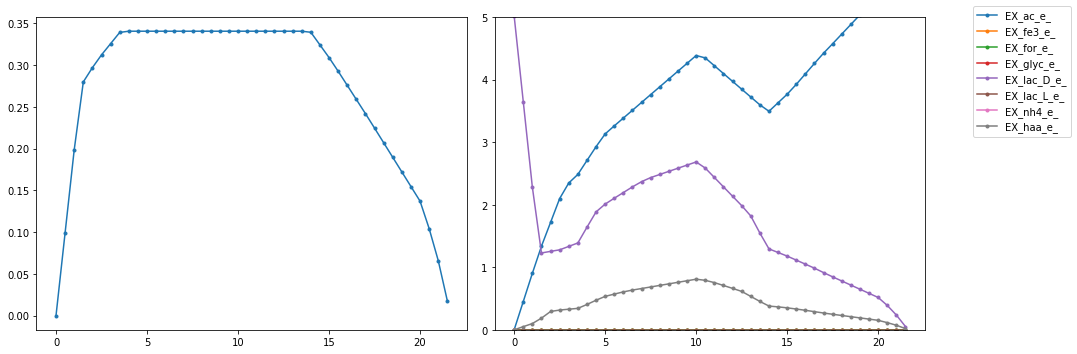

In [102]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

# plot biomass flux
ax[0].plot(fixed_producing_flux, max_biomass_flux, marker='.')
for index in exchange_flux_max.index:
    ax[1].plot(fixed_producing_flux, exchange_flux_max.loc[index].values, label=index, marker='.')
ax[1].legend()
ax[1].set_ylim([0,5])
ax[1].legend(bbox_to_anchor=(1.1, 1.05))

# for index in exchange_flux_max.index:
#     ax[2].plot(fixed_producing_flux, exchange_flux_max.loc[index].values, label=index)
# ax[2].legend()

plt.tight_layout()
plt.show()

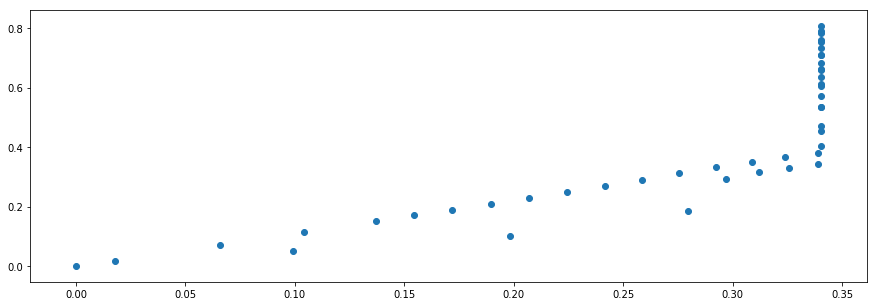

In [99]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.scatter(max_biomass_flux, exchange_flux_max.loc['EX_haa_e_'].values)